# Gridworld example with Q-learning and Sarsa

In [0]:
# importing the necessary libraries
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import random

<img src="http://drive.google.com/uc?export=view&id=18q7KL4aV6McMtaid_1Let2aGkw6d4QYn" width=45%>

In [0]:
class GridWorld:
    """
    The gridworls is a frequently used demo environment in reinforcement learning
    to try and test ideas.
    Today, we will use it to understand the concepts so far.
    
    The environment: (see image)
    * cells: the agent can step on a cell. There is exactly one cell to start from.
    This is the top left corner. There is one terminal cell where the walking ends, 
    the agent can not leave it (blue).
    * obstacles: there are cells where the agent can not step. (gray)
    * agent: it can move from one cell to an other neighboring cell. 
    Possible directions: up, down, left, right. Each transition happens with probability 1.
    * reward: after each transition the agent receives -1 point. In the terminal cell, no reward
    received anymore.
    
    Implement the environment below! You can use the implementation from the previous assignment!
    """
    def __init__(self, size, start_cell, obstacles, terminating_state):
        self.size = size
        self.start = start_cell
        self.obstacles = obstacles
        self.termin = terminating_state
        self.current_cell = self.start
    
    def reset(self):
        # ----- reset the current cell to the start cell to start again -----
        self.current_cell = self.start

    def transition(self, cell, action):
        # ----- IMPLEMENT FUNCTION -----
        # cell = (row, column) indices
        # action: 0 left, 1 up, 2 right, 3 down
        # returns: What will be the next state
        # Take care of the borders of the grid!
        
        # ....
        if action == 0 and cell[1]!= 0 and cell[1]-1 not in [obs[1] for obs in self.obstacles if obs[0] == cell[0]]:
          cell = [cell[0], cell[1] - 1]
        elif action == 1 and cell[0]!= 0 and cell[0]-1 not in [obs[0] for obs in self.obstacles if obs[1] == cell[1]]:
          cell = [cell[0] - 1, cell[1]]
        elif action == 2 and cell[0]!= 0 and cell[1]+1 != self.size[1] and cell[1]+1 not in [obs[1] for obs in self.obstacles if obs[0]==cell[0]]: 
          cell = (cell[0],cell[1]+1) 
        elif action == 3 and cell[0]+1 != self.size[0] and cell[0]+1 not in [obs[0] for obs in self.obstacles if obs[1]==cell[1]]:
          cell = (cell[0]+1,cell[1])

        self.current_cell = cell

        return cell

    def reward(self, cell, action):
        # ----- RETURN REWARD -----
        # -1 if not in the terminal state
        if cell!= self.termin and self.current_cell != self.termin:
          return -1
        else:
          return 0

    def in_terminal(self):
        return self.current_cell == self.termin

In [0]:
class QLearning:
    """
    In this class you can implement the Q-learning algorithm.
    The algorithm will run trajectories in the environment (grid world)
    and according to the transitions ()
    """
    def __init__(self, gridworld, gamma, alpha, episodes):
        self.gridworld = gridworld
        self.gamma = gamma
        self.alpha = alpha
        self.episodes = episodes
        # create table
        size = gridworld.size
        # ----- implement this -----
        self.q_table = np.zeros((4, size[0], size[1]))    # create a numpy matrix for storing the q-values for each actions and states
        # epsilon greedy
        self.eps = 0.9
        self.episode = 0
        # preformance summary
        self.sum_rewards = []
        self.path = []
    
    def update(self, cell, action, reward, next_cell):
        # the update rule for q-learning
        r_t, c_t = cell  # current state
        r_tp1, c_tp1 = next_cell  # next state
        # ----- implement the update rule -----
        max_q_new = max([self.q_table[act, r_tp1, c_tp1] for act in range(4)])
        self.q_table[action, r_t, c_t] = self.q_table[action, r_t, c_t] + self.alpha * (reward + self.gamma * max_q_new - self.q_table[action, r_t, c_t])

    def choose_action(self, cell):
        r, c = cell
        # ----- choose the next action accroding to epsilon-greedy -----
        
        # ...
        if np.random.uniform(0, 1) < self.eps:
          action = np.random.randint(4)
        else:
          action = np.argmax(self.q_table[:,r,c])
        return action
    
    def anneal_epsilon(self):
        # 1.5 - anneal earlier then the last episode
        # ----- Question: how does this function look like? -----
        # Answere: The lower the value of epsilon its more exploitation than exploration by the agent
        self.eps = max(0, self.eps * (1 - self.episode / self.episodes * 1.5))
    
    def one_episode(self):  # plays an episode
        # This function is responsible for running the agent 
        # for one episode.
        # During each transition, the Q-function is updated.
        # ----- implement the missing parts -----
        cntr = 0  # counter to avoid infinite loops when the agent stucks in the grid and can not reach the terminal state
        # ----- reset the gridworld -----
        self.gridworld.reset()
        # ----- append zero at the end of sum_rewards -----
        self.sum_rewards.append(0)
        # ---- cycle until termination (end of the current episode) or an upper limit (e.g. 5000)
        while not self.gridworld.in_terminal() and cntr < 5000:
            # ----- increase the counter -----
            cntr+= 1
            # ----- get the current cell -----
            cell = self.gridworld.current_cell
            # ----- choose the action -----
            action = self.choose_action(cell=cell)
            # ----- get the reward -----
            reward = self.gridworld.reward(cell=cell, action=action)
            # ----- make one transition and store -----
            next_cell = self.gridworld.transition(cell=cell, action=action)
            # ----- update the q-table -----
            self.update(cell=cell,action=action,reward=reward,next_cell=next_cell)
            # ----- add the reward to the last element in sum_rewards -----
            self.sum_rewards[-1] += reward
        # ----- anneal epsilon -----
        self.anneal_epsilon()
        # ----- increase the episode counter -----
        self.episode += 1
    
    def trajectory(self):
        self.gridworld.reset()
        self.path = []
        sum_rewards = 0
        itr = 0
        while not self.gridworld.in_terminal() and itr < 20:
            r, c = self.gridworld.current_cell
            action = np.argmax(self.q_table[:, r, c])
            self.gridworld.transition((r, c), action)
            sum_rewards += self.gridworld.reward((r, c), action)
            itr += 1
            self.path.append((r, c))
        return sum_rewards

    def is_learning_finished(self):  # depands on the number of episodes
        return self.episode > self.episodes

In [0]:
class Sarsa:
    
    def __init__(self, gridworld, gamma, alpha, episodes):
        self.gridworld = gridworld
        self.gamma = gamma
        self.alpha = alpha
        self.episodes = episodes
        # create table
        size = gridworld.size
        # ----- implement this -----
        self.q_table = np.zeros((4, size[0], size[1]))   # create a numpy matrix for storing the q-values for each actions and states
        # epsilon greedy
        self.eps = 0.9
        self.episode = 0
        # preformance summary
        self.sum_rewards = []
        self.path = []
    
    def update(self, cell, action, reward, next_cell, next_action):
        # the update rule for sarsa learning
        r_t, c_t = cell  # current state
        r_tp1, c_tp1 = next_cell  # next state
        # ----- implement the update rule -----
        q_next = self.q_table[next_action, r_tp1, c_tp1]
        self.q_table[action, r_t, c_t] = self.q_table[action, r_t, c_t] + self.alpha * (reward + self.gamma * q_next - self.q_table[action, r_t, c_t])
    
    def choose_action(self, cell):
        r, c = cell
        # ----- choose the next action accroding to epsilon-greedy -----
        
        # ...
        if np.random.uniform(0, 1) < self.eps:
          action = np.random.randint(4)
        else:
          action = np.argmax(self.q_table[:,r,c])
        return action
    
    def anneal_epsilon(self):
        # 1.5 - anneal earlier then the last episode
        self.eps = max(0, self.eps * (1 - self.episode / self.episodes * 1.5))
    
    def one_episode(self):  # plays an episode
        # ----- implement this -----
        # use the same logic like in Q-learning
        # be aware that this is an on-policy algorithm!
        # Question: Can you explain concisely what is the main difference
        # between on-policy and off-policy?
        # Answer:The difference is this:
        # In on-policy learning the 𝑄(𝑠,𝑎) function is learned from actions, we took using our current policy 𝜋.
        # In off-policy learning the 𝑄(𝑠,𝑎) function is learned from different actions (for example, random actions). We even don't need a policy at all!

        # This is the update function for the on-policy SARSA algorithm: 𝑄(𝑠,𝑎)←𝑄(𝑠,𝑎)+𝛼(𝑟+𝛾𝑄(𝑠′,𝑎′)−𝑄(𝑠,𝑎)), where 𝑎′ is the action, that was taken according to policy 𝜋.

        # Compare it with the update function for the off-policy Q-learning algorithm: 𝑄(𝑠,𝑎)←𝑄(𝑠,𝑎)+𝛼(𝑟+𝛾max𝑎′𝑄(𝑠′,𝑎′)−𝑄(𝑠,𝑎)), where 𝑎′ are all actions, that were probed in state 𝑠′.
        # Source: https://stats.stackexchange.com/questions/184657/what-is-the-difference-between-off-policy-and-on-policy-learning
        
        cntr = 0  
        # counter to avoid infinite loops when the agent stucks in the grid and can not reach the terminal state
        # ----- reset the gridworld -----
        self.gridworld.reset()
        # ----- append zero at the end of sum_rewards -----
        self.sum_rewards.append(0)
        # ---- cycle until termination (end of the current episode) or an upper limit (e.g. 5000)
        while not self.gridworld.in_terminal() and cntr < 5000:
            # ----- increase the counter -----
            cntr += 1
            # ----- get the current cell -----
            cell = self.gridworld.current_cell
            # ----- choose the action -----
            action = self.choose_action(cell=cell)
            # ----- get the reward -----
            reward = self.gridworld.reward(cell=cell, action=action)
            # ----- make one transition and store -----
            next_cell = self.gridworld.transition(cell=cell, action=action)
            # ----- choose next action -----
            next_action = self.choose_action(cell=next_cell)
            # ----- update the q-table -----
            self.update(cell=cell,action=action,reward=reward,next_cell=next_cell,next_action=action)
            # ----- add the reward to the last element in sum_rewards -----
            self.sum_rewards[-1] += reward
        # ----- anneal epsilon -----
        self.anneal_epsilon()
        # ----- increase the episode counter -----
        self.episode += 1

    def trajectory(self):
        self.gridworld.reset()
        self.path = []
        sum_rewards = 0
        itr = 0
        while not self.gridworld.in_terminal() and itr < 20:
            r, c = self.gridworld.current_cell
            action = np.argmax(self.q_table[:, r, c])
            self.gridworld.transition((r, c), action)
            sum_rewards += self.gridworld.reward((r, c), action)
            itr += 1
            self.path.append((r, c))
        return sum_rewards

    def is_learning_finished(self):
        return self.episode > self.episodes

In [0]:
def plot_learning_curve(ql):
    values = ql.sum_rewards
    x = list(range(len(values)))
    y = values
    plt.plot(x, y, 'ro')
    plt.show()

-420
-411
-63
-68
-60
-196
-98
-139
-43
-124
-67
-114
-30
-89
-78
-148
-91
-33
-80
-31
-19
-54
-21
-56
-92
-29
-36
-46
-42
-43
-38
-112
-47
-72
-69
-86
-58
-42
-86
-21
-32
-45
-47
-101
-37
-17
-23
-97
-71
-45
-31
-48
-77
-57
-94
-21
-18
-42
-36
-96
-13
-65
-21
-68
-15
-90
-37
-51
-14
-22
-20
-94
-18
-68
-38
-43
-44
-63
-23
-29
-59
-44
-42
-31
-61
-53
-15
-46
-50
-31
-28
-22
-78
-20
-77
-12
-27
-39
-58
-50
-39
-47
-36
-27
-77
-13
-19
-43
-61
-54
-22
-49
-32
-35
-36
-45
-22
-32
-31
-94
-32
-14
-28
-78
-39
-36
-53
-24
-36
-26
-37
-54
-56
-19
-11
-45
-45
-13
-43
-34
-55
-36
-32
-73
-22
-18
-55
-27
-23
-48
-28
-25
-51
-73
-30
-18
-64
-20
-39
-67
-19
-15
-20
-27
-93
-56
-20
-23
-18
-27
-63
-32
-33
-32
-32
-53
-26
-31
-56
-29
-32
-52
-30
-23
-37
-53
-43
-38
-52
-32
-13
-32
-46
-38
-50
-26
-19
-49
-40
-51
-26
-20


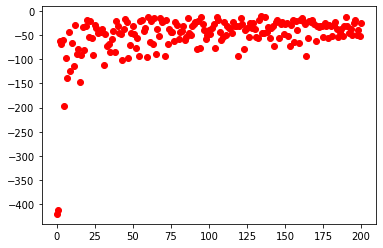

In [0]:
# grid world parameters
size = (6, 6)
start_cell = (0, 0)
obstacles = [(3, 3)]
terminating_state = (3, 5)
# q learning parameters
gamma = 0.9
alpha = 0.1
episodes = 200

gw = GridWorld(size, start_cell, obstacles, terminating_state)
solver = QLearning(gw, gamma, alpha, episodes)  # ----- try both of them -----

while not solver.is_learning_finished():
    solver.one_episode()
    sum_rewards = solver.sum_rewards[-1]
    print(sum_rewards)

sum_rewards = solver.trajectory()
print(sum_rewards)
plot_learning_curve(solver)

-355
-90
-683
-155
-67
-100
-46
-49
-22
-39
-88
-18
-278
-34
-20
-26
-24
-27
-24
-109
-80
-17
-35
-30
-37
-47
-32
-100
-48
-22
-55
-108
-24
-55
-29
-96
-15
-43
-93
-17
-108
-23
-17
-55
-64
-101
-66
-26
-25
-24
-130
-14
-43
-66
-50
-34
-48
-50
-20
-69
-59
-18
-38
-31
-80
-31
-86
-41
-17
-34
-48
-56
-57
-48
-50
-18
-24
-25
-29
-86
-36
-15
-50
-105
-29
-34
-25
-44
-79
-32
-32
-32
-32
-47
-49
-33
-36
-11
-25
-119
-14
-43
-40
-31
-59
-25
-39
-17
-68
-22
-19
-24
-52
-75
-66
-38
-37
-56
-13
-41
-31
-47
-14
-48
-37
-37
-40
-34
-23
-18
-70
-33
-30
-58
-60
-24
-39
-31
-57
-22
-13
-42
-28
-20
-134
-19
-22
-18
-18
-45
-44
-48
-44
-15
-35
-26
-24
-36
-86
-28
-19
-68
-23
-17
-88
-15
-13
-27
-19
-58
-43
-31
-18
-32
-26
-78
-51
-18
-18
-23
-59
-55
-18
-51
-27
-24
-55
-23
-14
-15
-58
-67
-30
-58
-15
-38
-23
-48
-40
-30
-29
-20


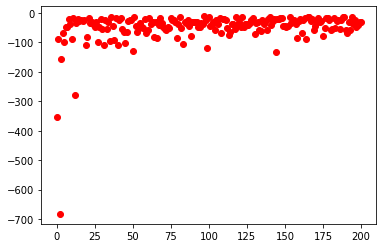

In [0]:
# grid world parameters
size = (6, 6)
start_cell = (0, 0)
obstacles = [(3, 3)]
terminating_state = (3, 5)
# q learning parameters
gamma = 0.9
alpha = 0.1
episodes = 200

gw = GridWorld(size, start_cell, obstacles, terminating_state)
 # ----- try both of them -----
solver = Sarsa(gw, gamma, alpha, episodes)

while not solver.is_learning_finished():
    solver.one_episode()
    sum_rewards = solver.sum_rewards[-1]
    print(sum_rewards)

sum_rewards = solver.trajectory()
print(sum_rewards)
plot_learning_curve(solver)